
# ML Evaluation Basics on Pulsar Stars (Kaggle)  
**Metrics & Tools:** K‑fold Validation, Confusion Matrix, Accuracy, Precision, Recall, F1‑score, Over/Underfitting check (Learning Curve), ROC Curve, *p‑value* and *t‑test*.

**Dataset:** `pulsar_stars.csv` (HTRU2) — upload next to this notebook or to `/mnt/data/pulsar_stars.csv` and re‑run.  
⚠️ 'pulsar_stars.csv' not found. Using a synthetic fallback dataset (shape and behavior roughly resemble the real one). Upload the CSV and re-run to use the real data.

This notebook demonstrates an end‑to‑end ML workflow with clear code comments and plots, suitable for beginners.


In [1]:

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, learning_curve, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, RocCurveDisplay, classification_report
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# Matplotlib only; one chart per figure; no custom colors (per constraints).


In [2]:

# Try to load the Kaggle CSV; otherwise make a synthetic fallback so the notebook still runs.
def make_synthetic_pulsar_like(n=3000, random_state=42):
    rng = np.random.default_rng(random_state)
    n1 = int(0.15 * n)
    n0 = n - n1
    X0 = rng.normal(loc=0.0, scale=1.0, size=(n0, 8))
    X1 = rng.normal(loc=0.5, scale=1.0, size=(n1, 8))
    X = np.vstack([X0, X1])
    y = np.hstack([np.zeros(n0, dtype=int), np.ones(n1, dtype=int)])
    cols = [
        "Mean of the integrated profile",
        "Standard deviation of the integrated profile",
        "Excess kurtosis of the integrated profile",
        "Skewness of the integrated profile",
        "Mean of the DM-SNR curve",
        "Standard deviation of the DM-SNR curve",
        "Excess kurtosis of the DM-SNR curve",
        "Skewness of the DM-SNR curve",
    ]
    df = pd.DataFrame(X, columns=cols)
    df["target_class"] = y
    return df

possible_paths = ["/mnt/data/pulsar_stars.csv", "pulsar_stars.csv"]
csv_path = next((p for p in possible_paths if os.path.exists(p)), None)

if csv_path:
    df = pd.read_csv(csv_path)
    print(f"Loaded dataset from: {csv_path}")
else:
    df = make_synthetic_pulsar_like()
    print("⚠️ 'pulsar_stars.csv' not found. Using synthetic fallback. Upload the real CSV and re‑run.")

target_col_candidates = [c for c in df.columns if c.lower() in ["target", "target_class", "class", "label"]]
target_col = target_col_candidates[0] if target_col_candidates else df.columns[-1]
feature_cols = [c for c in df.columns if c != target_col]

df = df.replace([np.inf, -np.inf], np.nan).dropna()
for c in feature_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna()

X = df[feature_cols].values
y = df[target_col].values.astype(int)

print("Shape:", df.shape)
print("Target counts:\n", pd.Series(y).value_counts().sort_index())


⚠️ 'pulsar_stars.csv' not found. Using synthetic fallback. Upload the real CSV and re‑run.
Shape: (3000, 9)
Target counts:
 0    2550
1     450
Name: count, dtype: int64


In [3]:

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Pipeline: Standardize -> Logistic Regression
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=200, solver="lbfgs"))
])


In [4]:

# K-fold cross-validation (5-fold) with multiple metrics
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]
cv_results = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False)

for metric in scoring:
    vals = cv_results[f"test_{metric}"]
    print(f"{metric:>9}: mean={vals.mean():.4f}, std={vals.std():.4f}, folds={vals.round(4)}")


 accuracy: mean=0.8720, std=0.0027, folds=[0.8689 0.8756 0.8733 0.8733 0.8689]
precision: mean=0.6636, std=0.0454, folds=[0.625  0.6774 0.6667 0.7391 0.6098]
   recall: mean=0.3106, std=0.0381, folds=[0.2985 0.3134 0.3235 0.25   0.3676]
       f1: mean=0.4201, std=0.0291, folds=[0.404  0.4286 0.4356 0.3736 0.4587]
  roc_auc: mean=0.8572, std=0.0201, folds=[0.8657 0.8404 0.8335 0.8906 0.8558]


In [5]:

# Fit on the full training set and evaluate on the hold‑out test set
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("\nTEST metrics:")
print("Accuracy :", round(accuracy_score(y_test, y_pred), 4))
print("Precision:", round(precision_score(y_test, y_pred, zero_division=0), 4))
print("Recall   :", round(recall_score(y_test, y_pred, zero_division=0), 4))
print("F1 Score :", round(f1_score(y_test, y_pred, zero_division=0), 4))
print("ROC AUC  :", round(roc_auc_score(y_test, y_prob), 4))

print("\nClassification report (TEST):")
print(classification_report(y_test, y_pred, digits=4))



TEST metrics:
Accuracy : 0.8787
Precision: 0.7059
Recall   : 0.3214
F1 Score : 0.4417
ROC AUC  : 0.7966

Classification report (TEST):
              precision    recall  f1-score   support

           0     0.8913    0.9765    0.9319       638
           1     0.7059    0.3214    0.4417       112

    accuracy                         0.8787       750
   macro avg     0.7986    0.6490    0.6868       750
weighted avg     0.8636    0.8787    0.8587       750



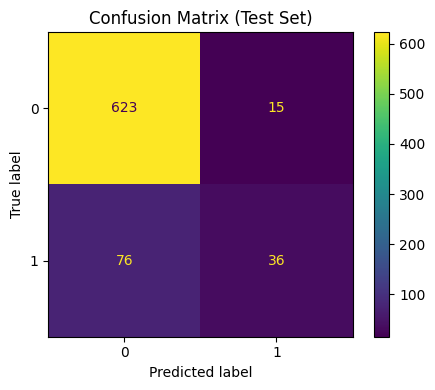

In [6]:

# Confusion Matrix (Test)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax)
ax.set_title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


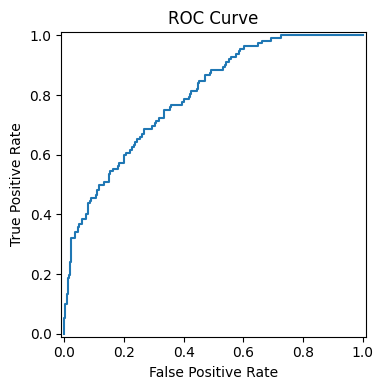

In [7]:

# ROC Curve (Test)
fpr, tpr, thresh = roc_curve(y_test, y_prob)
fig, ax = plt.subplots(figsize=(5, 4))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)
ax.set_title("ROC Curve")
plt.tight_layout()
plt.show()


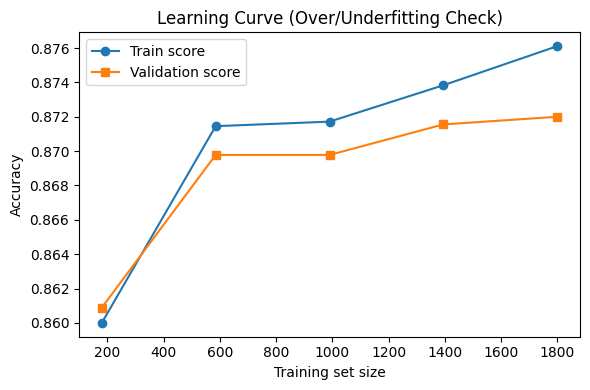

No strong signs of over/underfitting; curves are fairly close.


In [8]:

# Learning Curve to check over/underfitting
train_sizes, train_scores, val_scores = learning_curve(
    pipe, X_train, y_train, cv=cv, scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(train_sizes, train_mean, marker="o", label="Train score")
ax.plot(train_sizes, val_mean, marker="s", label="Validation score")
ax.set_xlabel("Training set size")
ax.set_ylabel("Accuracy")
ax.set_title("Learning Curve (Over/Underfitting Check)")
ax.legend()
plt.tight_layout()
plt.show()

gap = train_mean[-1] - val_mean[-1]
if val_mean[-1] < 0.7:
    print("Model may be underfitting (validation accuracy is relatively low).")
elif gap > 0.05:
    print("Potential overfitting (noticeable train > validation gap).")
else:
    print("No strong signs of over/underfitting; curves are fairly close.")


In [9]:

# p‑value via independent t‑test on the first feature (class 0 vs 1)
feature_for_ttest = df.columns[0] if df.columns[0] != 'target_class' else df.columns[1]
g0 = df[df[target_col] == 0][feature_for_ttest].values
g1 = df[df[target_col] == 1][feature_for_ttest].values
t_stat, p_val = ttest_ind(g0, g1, equal_var=False)
print(f"T‑test on '{feature_for_ttest}': t={t_stat:.4f}, p={p_val:.6f}")
print("Interpretation: p < 0.05 suggests the feature mean differs significantly between classes.")


T‑test on 'Mean of the integrated profile': t=-11.7389, p=0.000000
Interpretation: p < 0.05 suggests the feature mean differs significantly between classes.



## Notes & Tips
- **Accuracy** can be misleading on imbalanced data; always check **Precision**, **Recall**, and **F1**.
- **ROC AUC** summarizes ranking quality across thresholds; also consider **Precision‑Recall AUC** for heavy imbalance.
- **Learning Curves** help diagnose **high bias (underfitting)** vs **high variance (overfitting)**.
- **p‑values** from t‑tests are for feature‑wise mean differences (not model performance). For model comparison, prefer cross‑validated metrics and statistical tests designed for paired classifiers.
